In [16]:
import random

## Preparation

# Import the necessary libraries
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import optuna
import time

from activation import Swish, ResidualBlock, CLAHE

## Global Var

dataset_path = os.getcwd() + '/dataset/classified'

# scenario 1
# dataset_path = os.getcwd() + '/dataset/classified_additional_penelitian_full' # 1
# dataset_path = os.getcwd() + '/dataset/classified_half_and_full' # 2
# dataset_path = os.getcwd() + '/dataset/classified_add_phone_only' # 3

class_labels = ["Normal", "Cataract"]

In [17]:
print(f"Is using CUDA? {torch.cuda.is_available()}")  # Should return True if CUDA is available
print(torch.version.cuda)  # Check the CUDA version PyTorch is using
print(torch.cuda.current_device()) # Check CUDA device used

Is using CUDA? True
12.6
0


In [18]:
# Augmentation
# #1
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomRotation(15),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomCrop(224, padding=4),
#     transforms.RandomAutocontrast(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
# ])

# #2 highest accuracy
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop with scale variation
#     transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip
#     transforms.RandomRotation(20),  # Slightly increase rotation
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Add color variation
#     transforms.RandomAutocontrast(),  # Auto-contrast
#     transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),  # Enhance sharpness
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
# ])

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop with scale variation
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip
    transforms.RandomRotation(20),  # Slightly increase rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Add color variation
    transforms.RandomAutocontrast(),  # Auto-contrast
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),  # Enhance sharpness
    transforms.ToTensor(),
    # CLAHE(types='rgb', clip_limit=2.0, grid_size=(8, 8), padding=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

validation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load Dataset
ds = datasets.ImageFolder(root=dataset_path)

indices = list(range(len(ds)))
train_indices, validation_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_ds = Subset(ds, train_indices)
validation_ds = Subset(ds, validation_indices)

train_ds.dataset.transform = train_transform
validation_ds.dataset.transform = validation_transform

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
validation_loader = DataLoader(validation_ds, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)

total_samples  = len(train_ds) + len(validation_ds)

print(f"Train size: {(len(train_ds) / total_samples) * 100:.2f}%, Validation size: {(len(validation_ds) / total_samples) * 100:.2f}%")
print(f"Total samples: {total_samples}, Train size: {len(train_ds)}, Validation size: {len(validation_ds)}")

Train size: 79.98%, Validation size: 20.02%
Total samples: 1159, Train size: 927, Validation size: 232


In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(42)

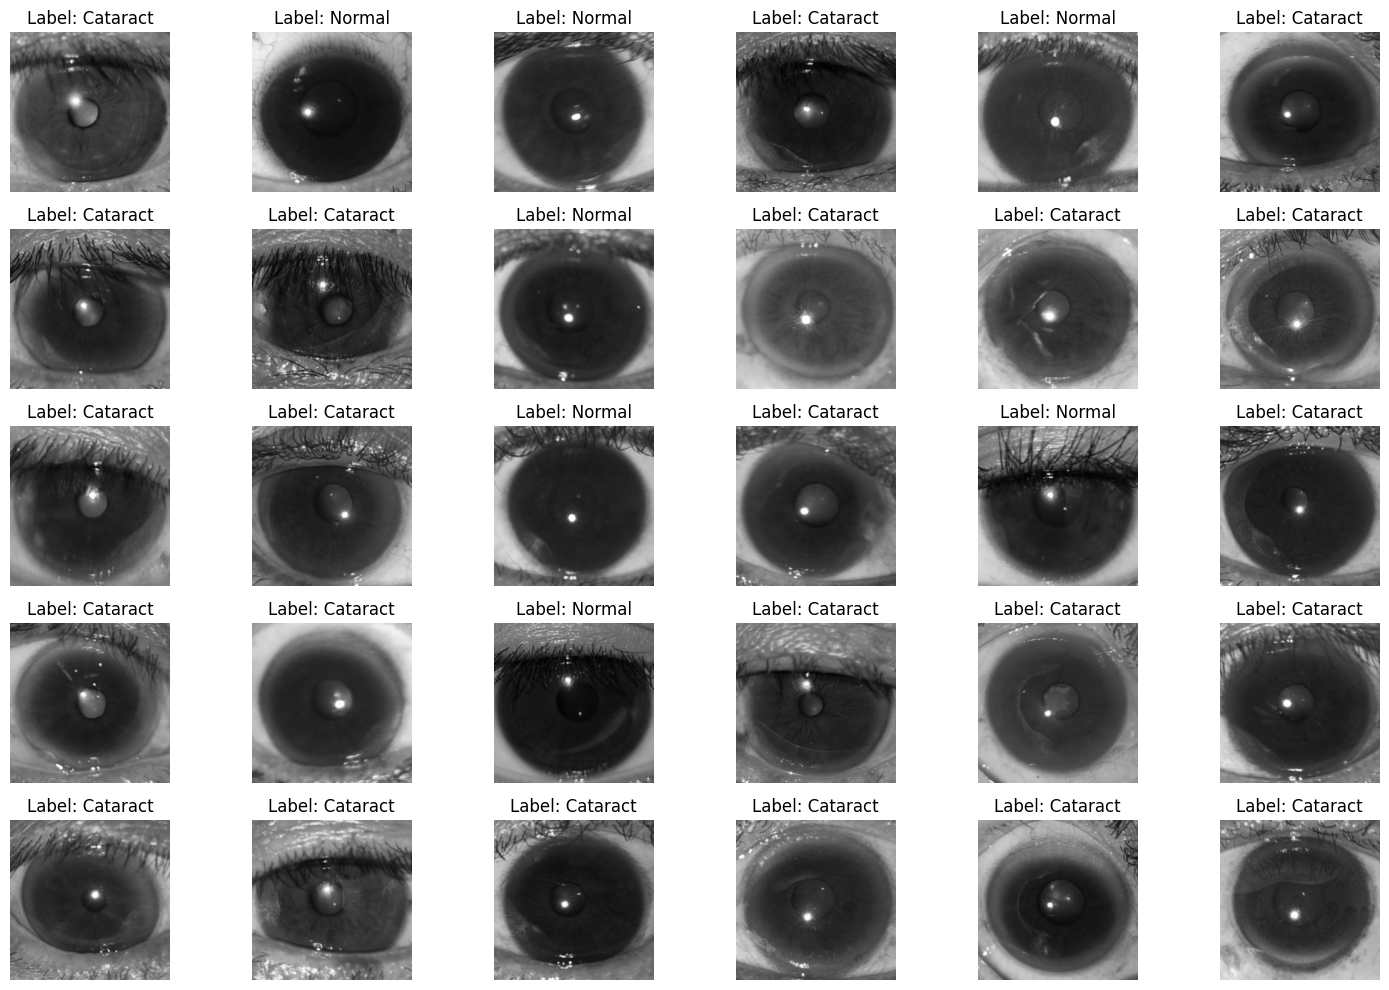

In [5]:
def denormalize(tensor, mean=None, std=None):
    if std is None:
        std = [0.229, 0.224, 0.225]
    if mean is None:
        mean = [0.485, 0.456, 0.406]
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean  # Reverse normalization

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

nrows = 5
ncols = 6
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for i in range(nrows * ncols):
    img = images[i]
    label = labels[i].item()

    img = denormalize(img)
    img = np.transpose(img.numpy(), (1, 2, 0))

    row = i // ncols
    col = i % ncols

    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Label: {class_labels[label]}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()



In [6]:
# Optuna Hyperparameter

best_trial = None
best_model = None

device_name = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = device_name == "cuda"


def objective(trial: optuna.Trial) -> float:
    device = torch.device(device_name)

    # Define hyperparameters
    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    # TODO:
    # 1. 0.00001 - 0.0001
    # 2. 0.001
    dropout_rate = trial.suggest_float("dropout", 0.3, 0.5)
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "RMSprop", "SGD"])
    num_epochs = trial.suggest_int("num_epochs", 10, 20)
    model_type = trial.suggest_categorical("model", ["efficientnet_b0", "efficientnet_b1", "efficientnet_b2"]) #
    scheduler_name = trial.suggest_categorical("scheduler", ["CosineAnnealingLR", "OneCycleLR"]) # , "StepLR", "ReduceLROnPlateau"
    # weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-3, log=True)

    # Best Hyperparameters: {'lr': 0.00803525510239778, 'dropout': 0.3233933125426155, 'optimizer': 'AdamW', 'num_epochs': 10}
    # Accuracy: 95.25862068965517
    # lr = 0.00803525510239778
    # dropout_rate = 0.3233933125426155
    # optimizer_name = "AdamW"
    # num_epochs = 15

    ------------ 0 -----1-----

    model = None
    match model_type:
        case "efficientnet_b2":
            model = models.efficientnet_b2(progress=True, weights=models.EfficientNet_B2_Weights.DEFAULT)
        case "efficientnet_b1":
            model = models.efficientnet_b1(progress=True, weights=models.EfficientNet_B1_Weights.DEFAULT)
        case _:
            model = models.efficientnet_b0(progress=True, weights=models.EfficientNet_B0_Weights.DEFAULT)

    for param in model.features[:-2].parameters():
        param.requires_grad = False

    number_of_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Linear(number_of_features, 256),
        nn.BatchNorm1d(256),
        Swish(),

        ResidualBlock(256, 256),
        nn.Dropout(dropout_rate),  # increased dropout

        ResidualBlock(256, 128),
        nn.BatchNorm1d(128),  # added batchnorm to help with stable training
        nn.Dropout(dropout_rate),

        ResidualBlock(128, 128),
        nn.Dropout(dropout_rate),

        # Removed ResidualBlock(128, 64) to reduce complexity

        nn.Linear(128, 64),  # lightweight linear compression instead of full residual
        nn.BatchNorm1d(64),
        Swish(),
        nn.Dropout(dropout_rate),

        nn.Linear(64, 1)
    ).to(device)

    model.to(device)

    # Define loss and optimizer
    criterion = nn.BCEWithLogitsLoss()

    match optimizer_name:
        case "AdamW":
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        case "SGD":
            momentum = trial.suggest_float("momentum", 0.85, 0.98)
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        case _:
            momentum = trial.suggest_float("momentum", 0.85, 0.98)
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)

    scheduler = None
    match scheduler_name:
        case "StepLR":
            step_lr_size = trial.suggest_int("step_size", 3, 10)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_lr_size, gamma=0.1)
        case "ReduceLROnPlateau":
            patience_lrp = trial.suggest_int("patience", 2, 6)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience_lrp, mode="max", factor=0.5)
        case "OneCycleLR":
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=lr,
                total_steps=num_epochs * len(train_loader),  # Total training steps
                pct_start=0.3,  # Portion of cycle increasing the learning rate
                anneal_strategy="cos",  # Cosine annealing
                div_factor=25,  # Initial LR is max_lr/div_factor
                final_div_factor=1e4,  # Minimum LR is max_lr/final_div_factor
            )
        case _:
            cosine_annealing_lr_t_max = trial.suggest_int("T_max", 10, 10)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cosine_annealing_lr_t_max)


    train_losses = []
    train_accuracies = []

    scaler = torch.amp.GradScaler(device=device_name)
    # epoch_progress = tqdm(range(num_epochs),
    #                       desc=f"Trial {trial.number} Epoch",
    #                       unit="epoch",
    #                       position=trial.number + 1,
    #                       leave=False,
    #                       file=sys.stdout)

    # Training Loop
    for epoch in range(num_epochs):

        model.train()
        total_loss, correct, total = 0, 0, 0

        # batch_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False, position=1, file=sys.stdout, dynamic_ncols=True)

        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)

            optimizer.zero_grad()

            with torch.amp.autocast("cuda", enabled=use_amp):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {(correct / total) * 100:.2f}%")

            # batch_progress.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)

        scheduler.step()

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = correct / total * 100

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
        # epoch_progress.set_postfix(loss=epoch_loss, accuracy=epoch_acc)
        # tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        trial.set_user_attr("train_losses", train_losses)
        trial.set_user_attr("train_accuracies", train_accuracies)

        # Pruning: Stop bad trials early
        trial.report(epoch_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Evaluate Model
    model.eval()
    correct, total = 0, 0
    trial_preds = []
    trial_labels = []

    with torch.no_grad():
        # validation_progress = tqdm(validation_loader, desc=f"Trial {trial.number} Evaluating", leave=False, position=trial.number + 100, file=sys.stdout)

        for images, labels in validation_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            trial_preds.extend(preds.cpu().numpy())
            trial_labels.extend(labels.cpu().numpy())

    validation_acc = correct / total * 100
    # tqdm.write(f"🎯 Validation Accuracy: {validation_acc:.2f}%")

    # **Save best model globally**
    global best_model, best_trial

    try:
        best_trial = trial.study.best_trial
        best_value = trial.study.best_value
    except ValueError:
        best_value = float('-inf')

    if best_model is None or (best_trial is not None and validation_acc > best_value):
        best_model = model.state_dict()

    best_acc = trial.study.user_attrs.get("best_accuracy", 0)

    if validation_acc > best_acc:
        study.set_user_attr("best_accuracy", validation_acc)

        trial_preds = np.array(trial_preds).flatten().tolist()
        trial_labels = np.array(trial_labels).flatten().tolist()

        study.set_user_attr("best_preds", trial_preds)
        study.set_user_attr("best_labels", trial_labels)

    return validation_acc

In [7]:
study = optuna.create_study(
    direction="maximize",
    study_name=f"hyperparam cataract classifier_{int(time.time())}",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(),
    storage="sqlite:///optuna.db",
    load_if_exists=True
)

is_use_early_stopping = True
if is_use_early_stopping:
    # Hyperparameter Optimization with Early Stopping
    n_trials = 20
    n_jobs = min(4, os.cpu_count())

    patience = 5
    best_acc = 0
    no_improvement_count = 0

    for trial_idx in range(n_trials):
        study.optimize(objective, n_trials=1, n_jobs=n_jobs)

        current_acc = study.best_value

        if current_acc > best_acc:
            best_acc = current_acc
            no_improvement_count = 0  # Reset counter if improvement occurs
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"Stopping early: No improvement in last {patience} trials.")
            break
else:
    study.optimize(
        objective,
        n_trials=10,
        n_jobs=1,
    )

acc = study.best_value

print("\nBest Hyperparameters:", study.best_params)
print("\nAccuracy:", acc)

[I 2025-06-02 14:03:39,165] A new study created in RDB with name: hyperparam cataract classifier_1748847818


Epoch [1/18], Loss: 0.7014, Accuracy: 46.09%
Epoch [1/18], Loss: 0.7045, Accuracy: 49.61%
Epoch [1/18], Loss: 0.7052, Accuracy: 48.44%
Epoch [1/18], Loss: 0.6811, Accuracy: 50.20%
Epoch [2/18], Loss: 0.6391, Accuracy: 65.62%
Epoch [2/18], Loss: 0.5995, Accuracy: 67.58%
Epoch [2/18], Loss: 0.5839, Accuracy: 70.31%
Epoch [2/18], Loss: 0.5811, Accuracy: 70.77%
Epoch [3/18], Loss: 0.5260, Accuracy: 78.12%
Epoch [3/18], Loss: 0.4995, Accuracy: 78.52%
Epoch [3/18], Loss: 0.4792, Accuracy: 77.60%
Epoch [3/18], Loss: 0.4723, Accuracy: 78.23%
Epoch [4/18], Loss: 0.4372, Accuracy: 85.94%
Epoch [4/18], Loss: 0.3658, Accuracy: 86.72%
Epoch [4/18], Loss: 0.3728, Accuracy: 86.72%
Epoch [4/18], Loss: 0.3506, Accuracy: 86.29%
Epoch [5/18], Loss: 0.3295, Accuracy: 89.06%
Epoch [5/18], Loss: 0.2714, Accuracy: 90.23%
Epoch [5/18], Loss: 0.2776, Accuracy: 89.84%
Epoch [5/18], Loss: 0.2026, Accuracy: 91.53%
Epoch [6/18], Loss: 0.1874, Accuracy: 96.09%
Epoch [6/18], Loss: 0.1768, Accuracy: 96.09%
Epoch [6/1

[I 2025-06-02 14:10:06,134] Trial 0 finished with value: 71.7741935483871 and parameters: {'lr': 0.001114479528229877, 'dropout': 0.3754504389562887, 'optimizer': 'RMSprop', 'num_epochs': 18, 'model': 'efficientnet_b2', 'scheduler': 'OneCycleLR', 'momentum': 0.850532174047453}. Best is trial 0 with value: 71.7741935483871.


Epoch [1/12], Loss: 0.7119, Accuracy: 46.88%
Epoch [1/12], Loss: 0.7270, Accuracy: 49.61%
Epoch [1/12], Loss: 0.7138, Accuracy: 48.96%
Epoch [1/12], Loss: 0.7209, Accuracy: 49.60%
Epoch [2/12], Loss: 0.6651, Accuracy: 50.00%
Epoch [2/12], Loss: 0.6776, Accuracy: 54.69%
Epoch [2/12], Loss: 0.6408, Accuracy: 58.07%
Epoch [2/12], Loss: 0.6296, Accuracy: 60.69%
Epoch [3/12], Loss: 0.6258, Accuracy: 67.97%
Epoch [3/12], Loss: 0.6013, Accuracy: 67.97%
Epoch [3/12], Loss: 0.5636, Accuracy: 70.83%
Epoch [3/12], Loss: 0.5629, Accuracy: 71.37%
Epoch [4/12], Loss: 0.5358, Accuracy: 75.00%
Epoch [4/12], Loss: 0.4912, Accuracy: 78.52%
Epoch [4/12], Loss: 0.4702, Accuracy: 80.21%
Epoch [4/12], Loss: 0.4741, Accuracy: 81.05%
Epoch [5/12], Loss: 0.4265, Accuracy: 85.16%
Epoch [5/12], Loss: 0.3944, Accuracy: 85.55%
Epoch [5/12], Loss: 0.3807, Accuracy: 85.42%
Epoch [5/12], Loss: 0.3301, Accuracy: 85.89%
Epoch [6/12], Loss: 0.3004, Accuracy: 91.41%
Epoch [6/12], Loss: 0.2493, Accuracy: 93.75%
Epoch [6/1

[I 2025-06-02 14:14:23,262] Trial 1 finished with value: 62.903225806451616 and parameters: {'lr': 0.00034295329114090246, 'dropout': 0.3496494105581486, 'optimizer': 'RMSprop', 'num_epochs': 12, 'model': 'efficientnet_b0', 'scheduler': 'OneCycleLR', 'momentum': 0.9108262852833691}. Best is trial 0 with value: 71.7741935483871.


Epoch [1/17], Loss: 0.7289, Accuracy: 46.88%
Epoch [1/17], Loss: 0.7099, Accuracy: 48.44%
Epoch [1/17], Loss: 0.6762, Accuracy: 52.08%
Epoch [1/17], Loss: 0.6697, Accuracy: 53.23%
Epoch [2/17], Loss: 0.6130, Accuracy: 70.31%
Epoch [2/17], Loss: 0.6265, Accuracy: 67.97%
Epoch [2/17], Loss: 0.5701, Accuracy: 69.79%
Epoch [2/17], Loss: 0.6089, Accuracy: 70.16%
Epoch [3/17], Loss: 0.4991, Accuracy: 77.34%
Epoch [3/17], Loss: 0.4495, Accuracy: 80.86%
Epoch [3/17], Loss: 0.4569, Accuracy: 80.21%
Epoch [3/17], Loss: 0.4590, Accuracy: 79.84%
Epoch [4/17], Loss: 0.3624, Accuracy: 90.62%
Epoch [4/17], Loss: 0.3751, Accuracy: 89.84%
Epoch [4/17], Loss: 0.3385, Accuracy: 90.36%
Epoch [4/17], Loss: 0.3095, Accuracy: 89.92%
Epoch [5/17], Loss: 0.3134, Accuracy: 91.41%
Epoch [5/17], Loss: 0.2742, Accuracy: 91.80%
Epoch [5/17], Loss: 0.2676, Accuracy: 92.19%
Epoch [5/17], Loss: 0.2292, Accuracy: 93.15%
Epoch [6/17], Loss: 0.2416, Accuracy: 92.97%
Epoch [6/17], Loss: 0.2044, Accuracy: 94.53%
Epoch [6/1

[I 2025-06-02 14:20:35,208] Trial 2 finished with value: 72.58064516129032 and parameters: {'lr': 0.00012005598644489632, 'dropout': 0.47188664265562164, 'optimizer': 'RMSprop', 'num_epochs': 17, 'model': 'efficientnet_b2', 'scheduler': 'CosineAnnealingLR', 'momentum': 0.929673221116103, 'T_max': 10}. Best is trial 2 with value: 72.58064516129032.


Epoch [1/17], Loss: 0.6895, Accuracy: 53.12%
Epoch [1/17], Loss: 0.6720, Accuracy: 56.25%
Epoch [1/17], Loss: 0.6636, Accuracy: 57.81%
Epoch [1/17], Loss: 0.6509, Accuracy: 60.28%
Epoch [2/17], Loss: 0.6377, Accuracy: 64.06%
Epoch [2/17], Loss: 0.5605, Accuracy: 70.31%
Epoch [2/17], Loss: 0.5552, Accuracy: 72.14%
Epoch [2/17], Loss: 0.5727, Accuracy: 71.77%
Epoch [3/17], Loss: 0.4983, Accuracy: 84.38%
Epoch [3/17], Loss: 0.4835, Accuracy: 84.38%
Epoch [3/17], Loss: 0.4846, Accuracy: 81.25%
Epoch [3/17], Loss: 0.4659, Accuracy: 81.85%
Epoch [4/17], Loss: 0.4168, Accuracy: 84.38%
Epoch [4/17], Loss: 0.4293, Accuracy: 83.20%
Epoch [4/17], Loss: 0.3796, Accuracy: 84.11%
Epoch [4/17], Loss: 0.3757, Accuracy: 84.68%
Epoch [5/17], Loss: 0.3239, Accuracy: 89.84%
Epoch [5/17], Loss: 0.3523, Accuracy: 89.06%
Epoch [5/17], Loss: 0.3178, Accuracy: 89.58%
Epoch [5/17], Loss: 0.3386, Accuracy: 89.11%
Epoch [6/17], Loss: 0.3033, Accuracy: 91.41%
Epoch [6/17], Loss: 0.2648, Accuracy: 92.19%
Epoch [6/1

[I 2025-06-02 14:26:43,505] Trial 3 finished with value: 73.38709677419355 and parameters: {'lr': 0.0016819251120564777, 'dropout': 0.42368750993080145, 'optimizer': 'AdamW', 'num_epochs': 17, 'model': 'efficientnet_b1', 'scheduler': 'CosineAnnealingLR', 'T_max': 10}. Best is trial 3 with value: 73.38709677419355.


Epoch [1/14], Loss: 0.6934, Accuracy: 52.34%
Epoch [1/14], Loss: 0.7220, Accuracy: 51.17%
Epoch [1/14], Loss: 0.7044, Accuracy: 50.52%
Epoch [1/14], Loss: 0.6835, Accuracy: 51.61%
Epoch [2/14], Loss: 0.7419, Accuracy: 42.97%
Epoch [2/14], Loss: 0.6924, Accuracy: 48.05%
Epoch [2/14], Loss: 0.6986, Accuracy: 47.66%
Epoch [2/14], Loss: 0.6971, Accuracy: 47.98%
Epoch [3/14], Loss: 0.6965, Accuracy: 51.56%
Epoch [3/14], Loss: 0.6757, Accuracy: 52.73%
Epoch [3/14], Loss: 0.6723, Accuracy: 55.47%
Epoch [3/14], Loss: 0.7273, Accuracy: 53.63%
Epoch [4/14], Loss: 0.7290, Accuracy: 40.62%
Epoch [4/14], Loss: 0.7078, Accuracy: 46.88%
Epoch [4/14], Loss: 0.6590, Accuracy: 52.60%
Epoch [4/14], Loss: 0.7016, Accuracy: 54.23%
Epoch [5/14], Loss: 0.6705, Accuracy: 63.28%
Epoch [5/14], Loss: 0.6607, Accuracy: 62.11%
Epoch [5/14], Loss: 0.6790, Accuracy: 63.02%
Epoch [5/14], Loss: 0.6712, Accuracy: 61.49%
Epoch [6/14], Loss: 0.6827, Accuracy: 58.59%
Epoch [6/14], Loss: 0.6714, Accuracy: 57.03%
Epoch [6/1

[I 2025-06-02 14:31:50,860] Trial 4 finished with value: 75.0 and parameters: {'lr': 0.000524280870442719, 'dropout': 0.3892184333570945, 'optimizer': 'AdamW', 'num_epochs': 14, 'model': 'efficientnet_b1', 'scheduler': 'OneCycleLR'}. Best is trial 4 with value: 75.0.


Epoch [1/10], Loss: 0.7221, Accuracy: 46.88%
Epoch [1/10], Loss: 0.6974, Accuracy: 51.17%
Epoch [1/10], Loss: 0.6928, Accuracy: 52.86%
Epoch [1/10], Loss: 0.7586, Accuracy: 51.21%
Epoch [2/10], Loss: 0.6946, Accuracy: 48.44%
Epoch [2/10], Loss: 0.7369, Accuracy: 47.27%
Epoch [2/10], Loss: 0.7079, Accuracy: 47.40%
Epoch [2/10], Loss: 0.7446, Accuracy: 47.18%
Epoch [3/10], Loss: 0.7151, Accuracy: 53.12%
Epoch [3/10], Loss: 0.7012, Accuracy: 53.12%
Epoch [3/10], Loss: 0.7788, Accuracy: 48.70%
Epoch [3/10], Loss: 0.7183, Accuracy: 48.59%
Epoch [4/10], Loss: 0.6550, Accuracy: 60.16%
Epoch [4/10], Loss: 0.6894, Accuracy: 59.38%
Epoch [4/10], Loss: 0.6908, Accuracy: 57.55%
Epoch [4/10], Loss: 0.7075, Accuracy: 56.65%
Epoch [5/10], Loss: 0.7197, Accuracy: 53.12%
Epoch [5/10], Loss: 0.6965, Accuracy: 54.30%
Epoch [5/10], Loss: 0.7125, Accuracy: 52.60%
Epoch [5/10], Loss: 0.6929, Accuracy: 52.42%
Epoch [6/10], Loss: 0.7337, Accuracy: 52.34%
Epoch [6/10], Loss: 0.7057, Accuracy: 52.34%
Epoch [6/1

[I 2025-06-02 14:35:43,581] Trial 5 finished with value: 69.35483870967742 and parameters: {'lr': 0.00021951058772334278, 'dropout': 0.49464457621111, 'optimizer': 'AdamW', 'num_epochs': 10, 'model': 'efficientnet_b2', 'scheduler': 'OneCycleLR'}. Best is trial 4 with value: 75.0.


Epoch [1/15], Loss: 0.7031, Accuracy: 53.12%
Epoch [1/15], Loss: 0.6592, Accuracy: 55.47%
Epoch [1/15], Loss: 0.6541, Accuracy: 58.59%
Epoch [1/15], Loss: 0.5775, Accuracy: 61.69%


[I 2025-06-02 14:36:19,009] Trial 6 pruned. 


Epoch [1/15], Loss: 0.7471, Accuracy: 43.75%
Epoch [1/15], Loss: 0.7235, Accuracy: 47.66%
Epoch [1/15], Loss: 0.6932, Accuracy: 47.92%
Epoch [1/15], Loss: 0.7082, Accuracy: 47.38%
Epoch [2/15], Loss: 0.7014, Accuracy: 51.56%
Epoch [2/15], Loss: 0.6666, Accuracy: 54.30%
Epoch [2/15], Loss: 0.6679, Accuracy: 56.25%
Epoch [2/15], Loss: 0.6346, Accuracy: 58.47%
Epoch [3/15], Loss: 0.6624, Accuracy: 57.81%
Epoch [3/15], Loss: 0.6313, Accuracy: 62.11%
Epoch [3/15], Loss: 0.6101, Accuracy: 64.32%
Epoch [3/15], Loss: 0.5831, Accuracy: 65.32%
Epoch [4/15], Loss: 0.5581, Accuracy: 78.91%
Epoch [4/15], Loss: 0.5614, Accuracy: 75.00%
Epoch [4/15], Loss: 0.5501, Accuracy: 74.74%
Epoch [4/15], Loss: 0.5704, Accuracy: 74.60%
Epoch [5/15], Loss: 0.4747, Accuracy: 84.38%
Epoch [5/15], Loss: 0.4767, Accuracy: 82.42%
Epoch [5/15], Loss: 0.4418, Accuracy: 82.29%
Epoch [5/15], Loss: 0.4103, Accuracy: 82.86%
Epoch [6/15], Loss: 0.4294, Accuracy: 80.47%
Epoch [6/15], Loss: 0.4242, Accuracy: 79.30%
Epoch [6/1

[I 2025-06-02 14:41:45,295] Trial 7 finished with value: 77.41935483870968 and parameters: {'lr': 0.0006352459255351203, 'dropout': 0.4558631193604288, 'optimizer': 'RMSprop', 'num_epochs': 15, 'model': 'efficientnet_b1', 'scheduler': 'OneCycleLR', 'momentum': 0.9667270784440907}. Best is trial 7 with value: 77.41935483870968.


Epoch [1/16], Loss: 0.7002, Accuracy: 53.12%
Epoch [1/16], Loss: 0.7029, Accuracy: 53.52%
Epoch [1/16], Loss: 0.6814, Accuracy: 55.47%
Epoch [1/16], Loss: 0.6478, Accuracy: 57.06%


[I 2025-06-02 14:42:20,649] Trial 8 pruned. 


Epoch [1/10], Loss: 0.7047, Accuracy: 51.56%
Epoch [1/10], Loss: 0.7122, Accuracy: 48.83%
Epoch [1/10], Loss: 0.7380, Accuracy: 49.48%
Epoch [1/10], Loss: 0.7287, Accuracy: 50.00%
Epoch [2/10], Loss: 0.7289, Accuracy: 51.56%
Epoch [2/10], Loss: 0.7313, Accuracy: 51.17%
Epoch [2/10], Loss: 0.7523, Accuracy: 48.44%
Epoch [2/10], Loss: 0.7189, Accuracy: 49.19%
Epoch [3/10], Loss: 0.7229, Accuracy: 49.22%
Epoch [3/10], Loss: 0.7425, Accuracy: 45.70%
Epoch [3/10], Loss: 0.7370, Accuracy: 47.14%
Epoch [3/10], Loss: 0.7221, Accuracy: 45.77%
Epoch [4/10], Loss: 0.6924, Accuracy: 55.47%
Epoch [4/10], Loss: 0.7444, Accuracy: 51.56%
Epoch [4/10], Loss: 0.7196, Accuracy: 51.56%
Epoch [4/10], Loss: 0.6709, Accuracy: 52.42%
Epoch [5/10], Loss: 0.7321, Accuracy: 46.88%
Epoch [5/10], Loss: 0.7335, Accuracy: 46.09%
Epoch [5/10], Loss: 0.7057, Accuracy: 48.44%
Epoch [5/10], Loss: 0.7261, Accuracy: 50.20%
Epoch [6/10], Loss: 0.7036, Accuracy: 50.78%
Epoch [6/10], Loss: 0.7156, Accuracy: 51.56%
Epoch [6/1

[I 2025-06-02 14:46:02,662] Trial 9 finished with value: 58.06451612903226 and parameters: {'lr': 0.001579622930871114, 'dropout': 0.4268817243004166, 'optimizer': 'SGD', 'num_epochs': 10, 'model': 'efficientnet_b0', 'scheduler': 'OneCycleLR', 'momentum': 0.8593862194188214}. Best is trial 7 with value: 77.41935483870968.


Epoch [1/20], Loss: 0.7297, Accuracy: 50.00%
Epoch [1/20], Loss: 0.7228, Accuracy: 50.00%
Epoch [1/20], Loss: 0.6971, Accuracy: 52.60%
Epoch [1/20], Loss: 0.7114, Accuracy: 52.82%
Epoch [2/20], Loss: 0.6890, Accuracy: 54.69%
Epoch [2/20], Loss: 0.7342, Accuracy: 51.17%
Epoch [2/20], Loss: 0.7370, Accuracy: 49.48%
Epoch [2/20], Loss: 0.7202, Accuracy: 48.59%
Epoch [3/20], Loss: 0.7080, Accuracy: 51.56%
Epoch [3/20], Loss: 0.6780, Accuracy: 57.03%
Epoch [3/20], Loss: 0.7166, Accuracy: 53.65%
Epoch [3/20], Loss: 0.7017, Accuracy: 53.63%
Epoch [4/20], Loss: 0.6990, Accuracy: 53.12%
Epoch [4/20], Loss: 0.6910, Accuracy: 56.25%
Epoch [4/20], Loss: 0.6940, Accuracy: 54.43%
Epoch [4/20], Loss: 0.7012, Accuracy: 54.84%
Epoch [5/20], Loss: 0.6979, Accuracy: 53.91%
Epoch [5/20], Loss: 0.7228, Accuracy: 50.39%
Epoch [5/20], Loss: 0.6998, Accuracy: 51.82%
Epoch [5/20], Loss: 0.6765, Accuracy: 53.83%
Epoch [6/20], Loss: 0.6858, Accuracy: 56.25%
Epoch [6/20], Loss: 0.6690, Accuracy: 57.81%
Epoch [6/2

[I 2025-06-02 14:53:05,919] Trial 10 finished with value: 75.80645161290323 and parameters: {'lr': 0.00274959389123987, 'dropout': 0.4553846340604388, 'optimizer': 'SGD', 'num_epochs': 20, 'model': 'efficientnet_b1', 'scheduler': 'CosineAnnealingLR', 'momentum': 0.9774205129414679, 'T_max': 10}. Best is trial 7 with value: 77.41935483870968.


Epoch [1/20], Loss: 0.7107, Accuracy: 50.78%
Epoch [1/20], Loss: 0.7267, Accuracy: 50.00%
Epoch [1/20], Loss: 0.7288, Accuracy: 49.22%
Epoch [1/20], Loss: 0.6521, Accuracy: 50.40%


[I 2025-06-02 14:53:39,692] Trial 11 pruned. 


Epoch [1/20], Loss: 0.6745, Accuracy: 58.59%
Epoch [1/20], Loss: 0.7130, Accuracy: 52.73%
Epoch [1/20], Loss: 0.7675, Accuracy: 49.22%
Epoch [1/20], Loss: 0.7700, Accuracy: 47.78%
Epoch [2/20], Loss: 0.7295, Accuracy: 50.00%
Epoch [2/20], Loss: 0.7175, Accuracy: 49.22%
Epoch [2/20], Loss: 0.7386, Accuracy: 48.96%
Epoch [2/20], Loss: 0.7189, Accuracy: 49.19%
Epoch [3/20], Loss: 0.6929, Accuracy: 52.34%
Epoch [3/20], Loss: 0.6915, Accuracy: 54.69%
Epoch [3/20], Loss: 0.7125, Accuracy: 53.12%
Epoch [3/20], Loss: 0.7090, Accuracy: 52.82%
Epoch [4/20], Loss: 0.7173, Accuracy: 50.78%
Epoch [4/20], Loss: 0.7500, Accuracy: 46.48%
Epoch [4/20], Loss: 0.6795, Accuracy: 52.08%
Epoch [4/20], Loss: 0.6993, Accuracy: 51.81%
Epoch [5/20], Loss: 0.6904, Accuracy: 55.47%
Epoch [5/20], Loss: 0.7175, Accuracy: 53.12%
Epoch [5/20], Loss: 0.6918, Accuracy: 52.34%
Epoch [5/20], Loss: 0.6743, Accuracy: 53.23%
Epoch [6/20], Loss: 0.6879, Accuracy: 54.69%
Epoch [6/20], Loss: 0.7062, Accuracy: 53.12%
Epoch [6/2

[I 2025-06-02 15:00:44,112] Trial 12 finished with value: 71.7741935483871 and parameters: {'lr': 0.0029976748306281753, 'dropout': 0.44597152371460314, 'optimizer': 'SGD', 'num_epochs': 20, 'model': 'efficientnet_b1', 'scheduler': 'CosineAnnealingLR', 'momentum': 0.9479825228999312, 'T_max': 10}. Best is trial 7 with value: 77.41935483870968.


Stopping early: No improvement in last 5 trials.

Best Hyperparameters: {'lr': 0.0006352459255351203, 'dropout': 0.4558631193604288, 'optimizer': 'RMSprop', 'num_epochs': 15, 'model': 'efficientnet_b1', 'scheduler': 'OneCycleLR', 'momentum': 0.9667270784440907}

Accuracy: 77.41935483870968


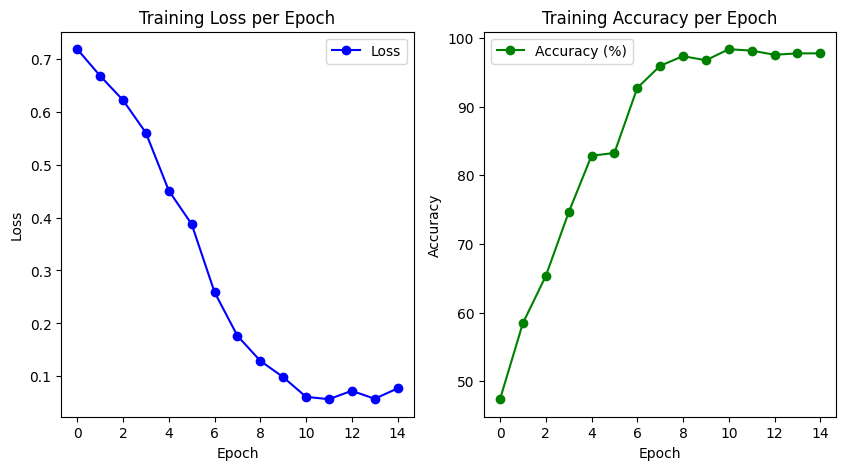

In [8]:
best_trial = study.best_trial
best_train_losses = best_trial.user_attrs.get("train_losses", [])
best_train_accuracies = best_trial.user_attrs.get("train_accuracies", [])

plt.figure(figsize=(10, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(best_train_losses, label="Loss", marker="o", linestyle="-", color="b")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(best_train_accuracies, label="Accuracy (%)", marker="o", linestyle="-", color="g")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Epoch")
plt.legend()

plt.show()

Accuracy: 77.42%
Loss (minimum): 0.0568
              precision    recall  f1-score   support

         0.0       0.78      0.75      0.77        61
         1.0       0.77      0.79      0.78        63

    accuracy                           0.77       124
   macro avg       0.77      0.77      0.77       124
weighted avg       0.77      0.77      0.77       124

Specificity: 0.7540983606557377
Sensitivity: 0.7936507936507936
Negative Predictive Value: 0.7796610169491526
Positive Predictive Value: 0.7692307692307693


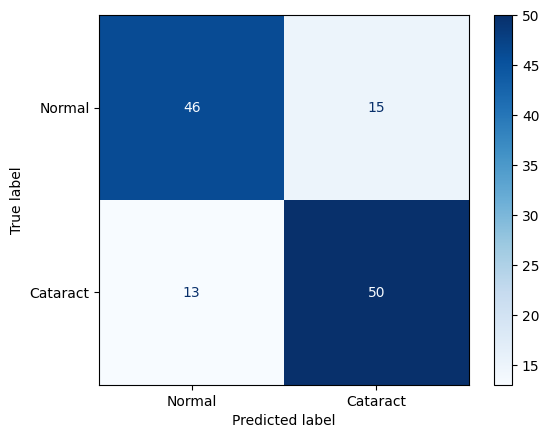

In [9]:
best_preds = np.array(study.user_attrs.get("best_preds", []))
best_labels = np.array(study.user_attrs.get("best_labels", []))
best_train_losses = best_trial.user_attrs["train_losses"]

conf_matrix = confusion_matrix(best_labels, best_preds)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap=plt.cm.Blues)
cr = classification_report(best_labels, best_preds)

print(f"Accuracy: {acc:.2f}%")
print(f"Loss (minimum): {min(best_train_losses):.4f}")
print(cr)
print("Specificity:", conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]))
print("Sensitivity:", conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1]))
print("Negative Predictive Value:", conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0]))
print("Positive Predictive Value:", conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1]))

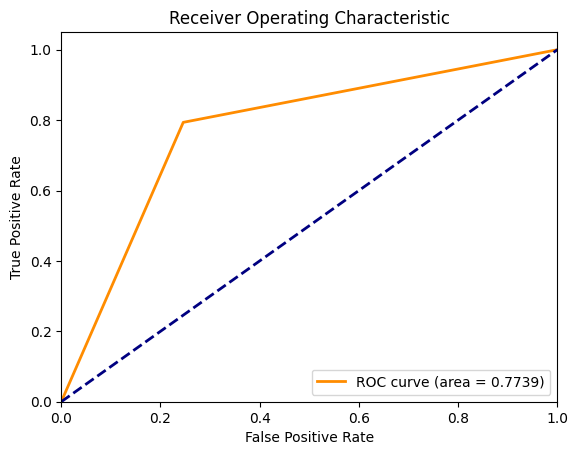

In [10]:
# ROC
fpr, tpr, _ = roc_curve(best_labels, best_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [11]:
# save
output_model_path = f"output/checkpoint-{acc}-hyperparam.pth"

torch.save({
    "model_state_dict": best_model,  # karena sudah OrderedDict
    "best_hyperparameters": study.best_params,
    "best_accuracy": study.best_value,
    "best_train_losses": best_train_losses,
    "best_train_accuracies": best_train_accuracies,
}, output_model_path)

In [12]:
print(output_model_path)

output/checkpoint-77.41935483870968-hyperparam.pth


In [13]:
from glob import glob
from PIL import Image

def evaluate_new_data(model_path, image_paths, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Evaluate new data using a trained model.

    Args:
        model_path (str): .pth model path.
        image_paths (list): list image to evaluate.
        device (str): 'cuda' or 'cpu'

    Returns:
        list: tuple contains (file name path, probability, label)
    """
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    state_dict = checkpoint["model_state_dict"]
    best_hparams = checkpoint["best_hyperparameters"]

    model_type = best_hparams.get("model", "efficientnet_b0")

    match model_type:
        case "efficientnet_b2":
            model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
        case "efficientnet_b1":
            model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
        case _:
            model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

    for param in model.features[:-2].parameters():
        param.requires_grad = False

    number_of_features = model.classifier[1].in_features
    dropout_rate = best_hparams.get("dropout", 0.3)

    model.classifier = nn.Sequential(
        nn.Linear(number_of_features, 256),
        nn.BatchNorm1d(256),
        Swish(),

        ResidualBlock(256, 256),
        nn.Dropout(dropout_rate),  # increased dropout

        ResidualBlock(256, 128),
        nn.BatchNorm1d(128),  # added batchnorm to help with stable training
        nn.Dropout(dropout_rate),

        ResidualBlock(128, 128),
        nn.Dropout(dropout_rate),

        # Removed ResidualBlock(128, 64) to reduce complexity

        nn.Linear(128, 64),  # lightweight linear compression instead of full residual
        nn.BatchNorm1d(64),
        Swish(),
        nn.Dropout(dropout_rate),

        nn.Linear(64, 1)
    ).to(device)

    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    # Prepare transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    results = []

    for path in image_paths:
        img = Image.open(path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            prob = torch.sigmoid(output).item()
            label = "Cataract" if prob > 0.5 else "Normal"
            results.append((os.path.basename(path), prob, label))

    return results

cataract_files = glob("./dataset/additional_penelitian/Katarak/*.jpg")
non_cataract_files = glob("./dataset/additional_penelitian/Non_Katarak/*.jpg")

model_path = output_model_path
# model_path = "./output/checkpoint-91.48148148148148-hyperparam.pth"

cataract_predictions = evaluate_new_data(model_path, cataract_files)
non_cataract_predictions = evaluate_new_data(model_path, non_cataract_files)

total_cataract_by_cadre = len(cataract_predictions)
total_non_cataract_by_cadre = len(non_cataract_predictions)

total_detected_cataract = 0
total_detected_non_cataract = 0

for file_name, prob, label in cataract_predictions:
    print(f"{file_name} -> Actual: Cataract, Probabilitas: {100 * prob:.4f}, Prediksi: {label}")
    if label == "Cataract":
        total_detected_cataract += 1

for file_name, prob, label in non_cataract_predictions:
    print(f"{file_name} -> Actual: Normal, Probabilitas: {100 * prob:.4f}, Prediksi: {label}")
    if label == "Normal":
        total_detected_non_cataract += 1


OD 1.jpg -> Actual: Cataract, Probabilitas: 99.9964, Prediksi: Cataract
OD 101.jpg -> Actual: Cataract, Probabilitas: 99.8495, Prediksi: Cataract
OD 104.jpg -> Actual: Cataract, Probabilitas: 99.9303, Prediksi: Cataract
OD 109.jpg -> Actual: Cataract, Probabilitas: 99.9389, Prediksi: Cataract
OD 110.jpg -> Actual: Cataract, Probabilitas: 99.7292, Prediksi: Cataract
OD 112.jpg -> Actual: Cataract, Probabilitas: 99.9587, Prediksi: Cataract
OD 121.jpg -> Actual: Cataract, Probabilitas: 99.9967, Prediksi: Cataract
OD 126.jpg -> Actual: Cataract, Probabilitas: 99.9682, Prediksi: Cataract
OD 127.jpg -> Actual: Cataract, Probabilitas: 0.1392, Prediksi: Normal
OD 133.jpg -> Actual: Cataract, Probabilitas: 97.5864, Prediksi: Cataract
OD 136.jpg -> Actual: Cataract, Probabilitas: 99.9408, Prediksi: Cataract
OD 137.jpg -> Actual: Cataract, Probabilitas: 99.9790, Prediksi: Cataract
OD 138.jpg -> Actual: Cataract, Probabilitas: 99.9666, Prediksi: Cataract
OD 140.jpg -> Actual: Cataract, Probabilita

In [14]:
percentage_cataract = (total_detected_cataract / total_cataract_by_cadre) * 100
percentage_non_cataract = (total_detected_non_cataract / total_non_cataract_by_cadre) * 100

print(f"\nTotal Cataract Eye: {total_cataract_by_cadre}, Detected Cataract: {total_detected_cataract}", f"({percentage_cataract:.2f}%)")
print(f"Total Normal Eye: {total_non_cataract_by_cadre}, Detected Normal: {total_detected_non_cataract}, {percentage_non_cataract:.2f}%)")

total_percentage = (total_detected_cataract + total_detected_non_cataract) / (total_cataract_by_cadre + total_non_cataract_by_cadre) * 100
print(f"Accuracy Detection: {total_percentage:.2f}%")


Total Cataract Eye: 188, Detected Cataract: 172 (91.49%)
Total Normal Eye: 188, Detected Normal: 177, 94.15%)
Accuracy Detection: 92.82%
